In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
from scipy.signal import convolve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configurations for Sine-circle  Map and model
class Config:
    K_chaotic = 2.3
    K_non_chaotic = 2.1
    K_C_T = 2.4
    K_NC_T = 2.0
    omega = 0.606661
    x0 = np.random.rand()
    length = 5000
    #sampling_rate = 44100

    # Model parameters
    input_shape = (10000, 1)
    num_classes = 2  # Binary classification
    learning_rate = 1e-4
    l2_lambda = 0.001

    # File paths
    data_file_path = 'truncated_audio_files_and_labels_Automatic_Speechsine_circle.npz'
    best_model_path = 'best_model_Automatic_Speech_.keras'
    best_model_path_1 = 'best_model_Automatic_Speech_1.keras'
    best_model_path_2 = 'best_model_Automatic_Speech_2.keras'
    best_model_path_3 = 'best_model_Automatic_Speech_3.keras'
    best_model_path_4 = 'best_model_Automatic_Speech_4.keras'
    best_model_path_5 = 'best_model_Automatic_Speech_5.keras'
    best_model_path_new = 'best_model_Automatic_Speech_new.keras'
    best_model_path_r = 'best_model_resnet2.keras'
    best_model_path_s = 'best_model_automatic_speaker_ssdnet.keras'
    best_model_path_i = 'best_model_automatic_speaker_incnet1d.keras'
    best_model_path_m = 'best_model_incnet1d_m.keras'
    best_model_path_m2 = 'best_model_incnet1d_m2.keras'
    best_model_path_rtssd = 'best_model_Automatic_Speaker_restssd_sinecircle.keras'

In [ ]:
# Loading data
metadata = pd.read_csv('/content/drive/MyDrive/Automatic_Speaker_Experiments/Automatic Speaker/metadata.csv')
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['Bonafide'])

In [ ]:
def load_audio_file(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        return audio
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading {file_path}: {e}")
        return None

In [ ]:
# Function to load audio files and labels with detailed debug information
def load_Automatic_Speech(data_path, metadata):
    audio_files = []
    labels = []
    for index, row in metadata.iterrows():
        # Directly access the filename without fold subdirectories
        file_path = os.path.join(data_path, row['File Name'])
        audio = load_audio_file(file_path)
        audio_files.append(audio)
        labels.append(row['label'])
    return audio_files, np.array(labels)

In [ ]:
# Load audio files and labels
audio_files, labels = load_Automatic_Speech('/content/drive/MyDrive/Automatic_Speaker_Experiments/Automatic Speaker/audio', metadata)
#audio_files, labels = load_ESC50('/content/drive/MyDrive/Dataset1/audio', metadata)

In [ ]:
# Truncating audio files
min_length = min(len(audio) for audio in audio_files)
print(min_length)

15116


In [ ]:
audio_files_truncated = [audio[:10000] for audio in audio_files]

In [ ]:
# Converting to numpy arrays
audio_files_array = np.array(audio_files_truncated)
labels_array = np.array(labels)

In [ ]:
# Print the shape of the truncated audio files array and labels array
print(f'Shape of truncated audio files array: {audio_files_array.shape}')
print(f'Shape of labels array: {labels_array.shape}')

Shape of truncated audio files array: (3565, 10000)
Shape of labels array: (3565,)


In [ ]:
# Saving numpy arrays to a file
np.savez(Config.data_file_path, audio_files=audio_files_array, labels=labels_array)

In [ ]:
# Loading arrays
loaded_data = np.load(Config.data_file_path)
audio_files_array = loaded_data['audio_files']
labels_array = loaded_data['labels']

In [ ]:
labels = labels_array

In [ ]:
def sine_circle_map(omega, K, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = (x[i-1] + omega - (K / (2 * np.pi)) * np.sin(2 * np.pi * x[i-1])) % 1
    return x

In [ ]:
print(f'K_chaotic = {Config.K_chaotic}')
print(f'K_non_chaotic = {Config.K_non_chaotic}')
print(f'x0 = {Config.x0}')
print(f'length = {Config.length}')

K_chaotic = 2.3
K_non_chaotic = 2.1
x0 = 0.9193900152147426
length = 5000


In [ ]:
#Add
print(f'K_chaotic_T = {Config.K_C_T}')
print(f'K_non_chaotic_T = {Config.K_NC_T}')

K_chaotic_T = 2.4
K_non_chaotic_T = 2.0


In [ ]:
chaotic_series = sine_circle_map(Config.omega, Config.K_chaotic, Config.x0, Config.length)
non_chaotic_series = sine_circle_map(Config.omega, Config.K_non_chaotic, Config.x0, Config.length)

In [ ]:
#Add
chaotic_series_T = sine_circle_map(Config.omega, Config.K_C_T, Config.x0, Config.length)
non_chaotic_series_T = sine_circle_map(Config.omega, Config.K_NC_T, Config.x0, Config.length)

In [ ]:
print(chaotic_series)

[9.19390015e-01 7.03628145e-01 6.60917426e-01 ... 4.67733817e-01
 6.89921937e-04 6.05764106e-01]


In [ ]:
print(non_chaotic_series)

[0.91939002 0.68818666 0.60418059 ... 0.54705467 0.25109717 0.52354073]


In [ ]:
#Add
print(chaotic_series_T)
print(non_chaotic_series_T)

[0.91939002 0.71134889 0.6887732  ... 0.29024208 0.52707649 0.19840804]
[0.91939002 0.68046591 0.57553782 ... 0.51977311 0.16587868 0.49766659]


In [ ]:
MAX_chaotic = 0.9993632086366939
chaotic_series_normalized = chaotic_series / MAX_chaotic
print(chaotic_series_normalized)

[9.19975848e-01 7.04076495e-01 6.61338561e-01 ... 4.68031856e-01
 6.90361554e-04 6.06150098e-01]


In [ ]:
MAX_non_chaotic = 0.9993375202604273
non_chaotic_series_normalized = non_chaotic_series / MAX_non_chaotic
print(non_chaotic_series_normalized)

[0.9199995  0.68864287 0.60458111 ... 0.54741732 0.25126362 0.52388779]


In [ ]:
#Add
MAX_chaotic = 0.9982397807380526
chaotic_series_normalized_T = chaotic_series_T / MAX_chaotic
print(chaotic_series_normalized_T)

[0.9210112  0.71260323 0.68998773 ... 0.29075388 0.52800589 0.1987579 ]


In [ ]:
#Add
MAX_non_chaotic = 0.9921288494162146
non_chaotic_series_normalized_T = non_chaotic_series_T / MAX_non_chaotic
print(non_chaotic_series_normalized_T)

[0.92668409 0.68586445 0.58010391 ... 0.52389678 0.16719469 0.50161488]


In [ ]:
# Convolution functions
def convolve_with_series(audio, series):
    return convolve(audio, series, mode='same')

In [ ]:
# Convolve each audio sample with chaotic and non-chaotic time series
audio_files_chaotic = [convolve_with_series(audio, chaotic_series_normalized) for audio in audio_files_array]
audio_files_chaotic = np.array(audio_files_chaotic)

audio_files_non_chaotic = [convolve_with_series(audio, non_chaotic_series_normalized) for audio in audio_files_array]
audio_files_non_chaotic = np.array(audio_files_non_chaotic)

In [ ]:
#Add
# Convolve each audio sample with chaotic and non-chaotic time series
audio_files_chaotic_T = [convolve_with_series(audio, chaotic_series_normalized_T) for audio in audio_files_array]
audio_files_chaotic_T = np.array(audio_files_chaotic_T)

audio_files_non_chaotic_T = [convolve_with_series(audio, non_chaotic_series_normalized_T) for audio in audio_files_array]
audio_files_non_chaotic_T = np.array(audio_files_non_chaotic_T)

In [ ]:
def normalize_audio_standard_scaled(audio):
    mean = np.mean(audio)
    std = np.std(audio)
    print(f'Mean: {mean}, Standard Deviation: {std}')
    if(std!=0):
      audio = (audio - mean) / std
    else:
      audio = audio
    min_val = np.min(audio)
    max_val = np.max(audio)
    scaled_audio = 2 * (audio - min_val) / (max_val - min_val) - 1
    print(f'Min Value: {min_val}, Max Value: {max_val}')
    print(f'Scaled Min Value: {np.min(scaled_audio)}, Scaled Max Value: {np.max(scaled_audio)}')
    return scaled_audio

In [ ]:
audio_files_chaotic_normalized = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_chaotic])
audio_files_non_chaotic_normalized = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_non_chaotic])

Streaming output truncated to the last 5000 lines.
Min Value: -5.861314359900035, Max Value: 5.705829611248361
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.11880310884126145, Standard Deviation: 0.6605746168407332
Min Value: -7.42783139468516, Max Value: 7.9945761530996196
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -1.7189496631873895, Standard Deviation: 1.1656028895253665
Min Value: -4.0948001870731385, Max Value: 3.063985313204295
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -1.42893449503583, Standard Deviation: 10.162460126044303
Min Value: -5.124390818753207, Max Value: 0.7765992676009454
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.18828931303294802, Standard Deviation: 0.15052178316022014
Min Value: -5.121191533775235, Max Value: 5.236078791993299
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.3847559477933425, Standard Deviation: 0.2887926940071483
Min Value: -2.1077358503234485, Max Value: 1.0444678536003553
Scaled Min Value: -1.0, 

In [ ]:
#Add
audio_files_chaotic_normalized_T = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_chaotic_T])
audio_files_non_chaotic_normalized_T = np.array([normalize_audio_standard_scaled(audio) for audio in audio_files_non_chaotic_T])

Streaming output truncated to the last 5000 lines.
Min Value: -5.246264212871089, Max Value: 6.043924387846845
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.1129500653858679, Standard Deviation: 0.6188430211939248
Min Value: -7.485347310451074, Max Value: 8.213242239185616
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -1.6357573537177375, Standard Deviation: 0.9410674197543395
Min Value: -3.2533293635117517, Max Value: 2.840589337475762
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -1.369453462051982, Standard Deviation: 9.689839333515653
Min Value: -5.125627225562899, Max Value: 0.7749436021196285
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.17923708767761173, Standard Deviation: 0.12315227032913646
Min Value: -5.903847288260869, Max Value: 4.265715135160788
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -0.3663819693696559, Standard Deviation: 0.2746379609643108
Min Value: -2.023081000718739, Max Value: 1.0475991187913634
Scaled Min Value: -1.0, Sc

PLOT THE WAVEFORM.

In [ ]:
# Function to plot the waveform of an audio file
def plot_waveform(audio, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# Function to load and return audio as numpy array
def load_audio(file_path, sr=22050):
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

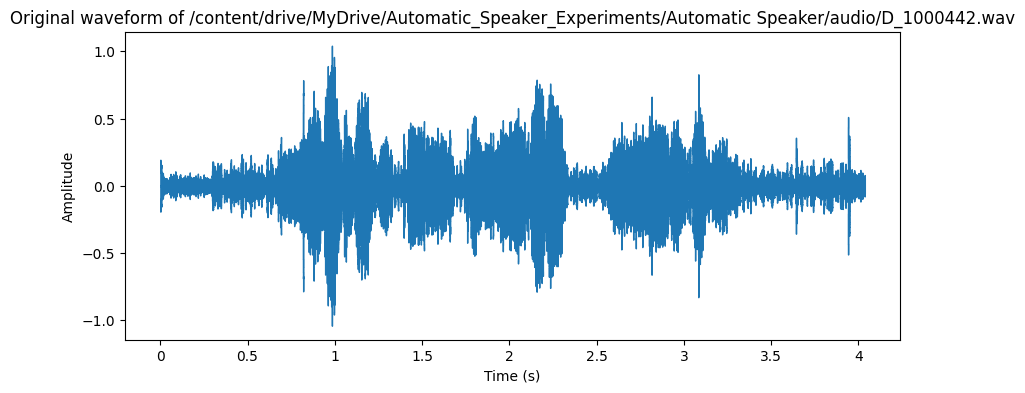

In [ ]:
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
# List of audio file paths
audio_files = [
    '/content/drive/MyDrive/Automatic_Speaker_Experiments/Automatic Speaker/audio/D_1000006.wav',
    '/content/drive/MyDrive/Automatic_Speaker_Experiments/Automatic Speaker/audio/E_1002090.wav',
    '/content/drive/MyDrive/Automatic_Speaker_Experiments/Automatic Speaker/audio/D_1000442.wav',
    '/content/drive/MyDrive/Automatic_Speaker_Experiments/Automatic Speaker/audio/D_1000048.wav',
    '/content/drive/MyDrive/Automatic_Speaker_Experiments/Automatic Speaker/audio/D_1000363.wav'
]
#Then load the audio file
file_path = audio_files[2]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

Mean: 0.0004079143109265715, Standard Deviation: 0.15278641879558563
Min Value: -6.8221755027771, Max Value: 6.269885540008545
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: 106.71295204498976, Standard Deviation: 22.29368761019544
Min Value: -2.653399158923782, Max Value: 2.484654207053679
Scaled Min Value: -1.0, Scaled Max Value: 1.0


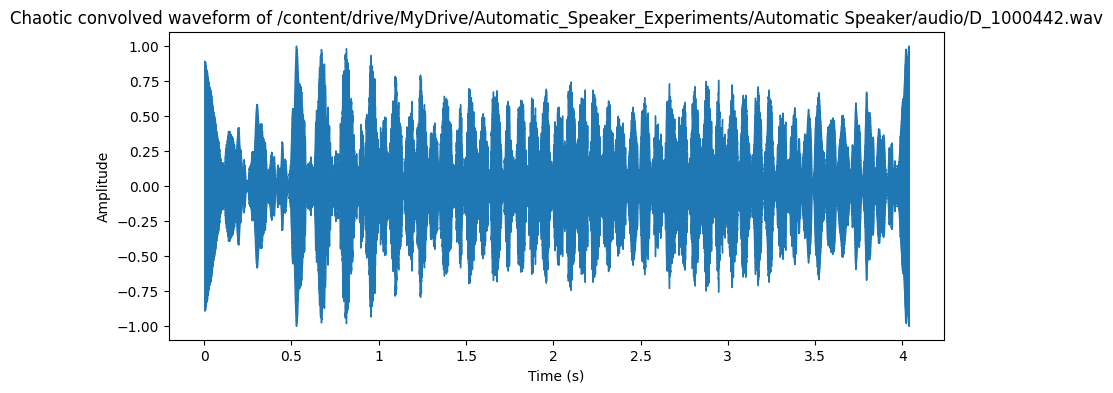

Mean: 70.19844561345813, Standard Deviation: 14.61574671084152
Min Value: -2.6872751822775953, Max Value: 2.53096156733632
Scaled Min Value: -1.0, Scaled Max Value: 1.0


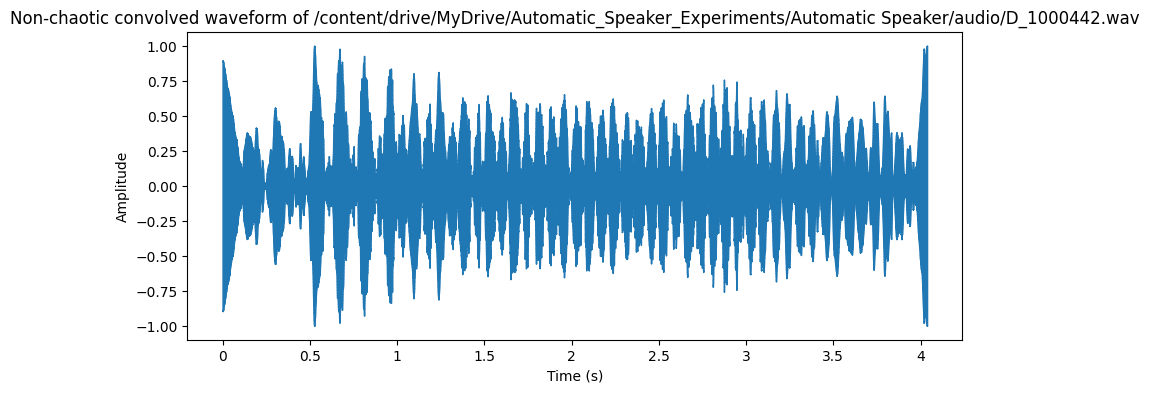

In [ ]:
# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

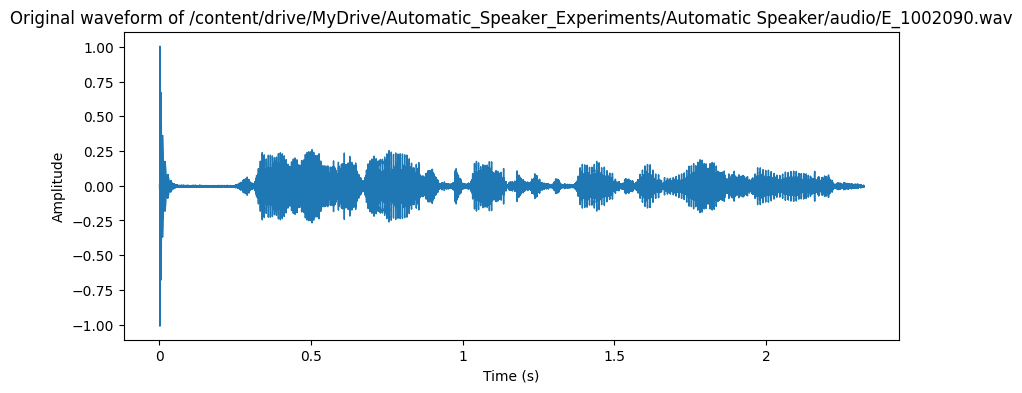

Mean: -7.293286034837365e-05, Standard Deviation: 0.05887644737958908
Min Value: -11.455921173095703, Max Value: 17.122604370117188
Scaled Min Value: -1.0, Scaled Max Value: 1.0
Mean: -498.7572763826608, Standard Deviation: 44.26480366220021
Min Value: -0.4822005464374646, Max Value: 5.50078951495217
Scaled Min Value: -1.0, Scaled Max Value: 1.0


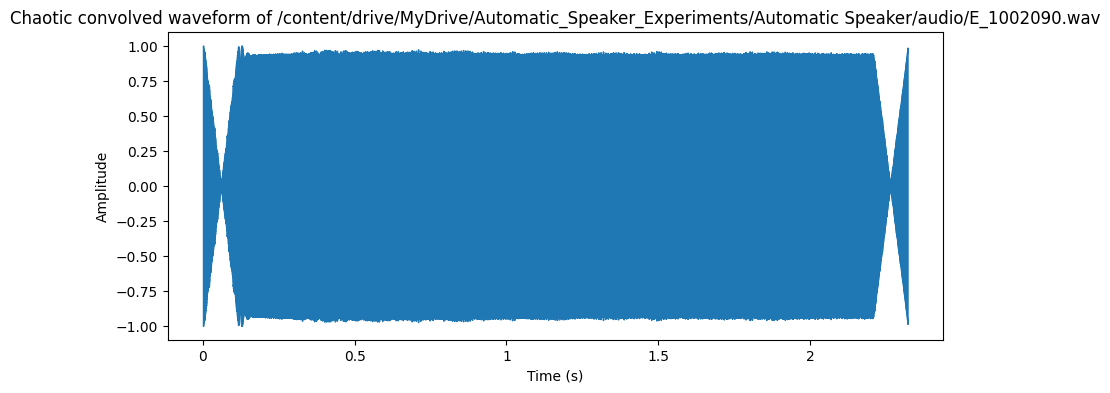

Mean: -328.06534425141945, Standard Deviation: 29.22787539171957
Min Value: -0.47628817841298804, Max Value: 5.481496169925214
Scaled Min Value: -1.0, Scaled Max Value: 1.0


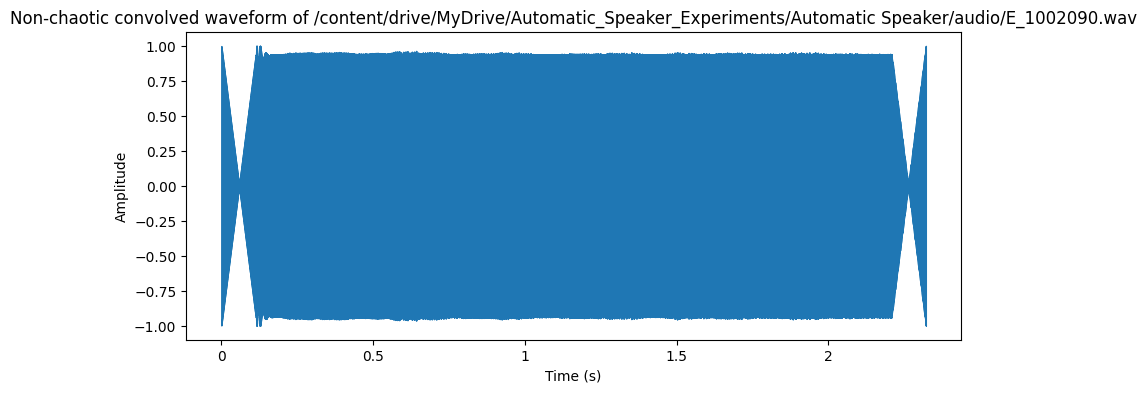

In [ ]:
file_path = audio_files[1]
audio, sr = load_audio(file_path)
plot_waveform(audio, sr, f'Original waveform of {file_path}')

# Convolve with chaotic series and play/plot the result
audio_normalized = normalize_audio_standard_scaled(audio)

audio_chaotic = convolve_with_series(audio_normalized, chaotic_series_normalized)
audio_chaotic_scaled = normalize_audio_standard_scaled(audio_chaotic)
plot_waveform(audio_chaotic_scaled, sr, f'Chaotic convolved waveform of {file_path}')

# Convolve with non-chaotic series and play/plot the result

audio_non_chaotic = convolve_with_series(audio_normalized, non_chaotic_series_normalized)
audio_non_chaotic_scaled = normalize_audio_standard_scaled(audio_non_chaotic)
plot_waveform(audio_non_chaotic_scaled, sr, f'Non-chaotic convolved waveform of {file_path}')

In [ ]:
# Binary classification labels
labels_chaotic = np.ones(len(labels_array))
labels_non_chaotic = np.zeros(len(labels_array))

In [ ]:
# Concatenating audio files and labels
audio_files_augmented = np.concatenate((audio_files_chaotic_normalized, audio_files_non_chaotic_normalized), axis=0)
labels_augmented = np.concatenate((labels_chaotic, labels_non_chaotic), axis=0)

In [ ]:
#Add
# Concatenating audio files and labels
audio_files_augmented_T = np.concatenate((audio_files_chaotic_normalized_T, audio_files_non_chaotic_normalized_T), axis=0)
labels_augmented_T = np.concatenate((labels_chaotic, labels_non_chaotic), axis=0)

In [ ]:
# Encoding labels
encoder = LabelEncoder()
labels_augmented_encoded = encoder.fit_transform(labels_augmented)

In [ ]:
#Add
# Encoding labels
encoder = LabelEncoder()
labels_augmented_encoded_T = encoder.fit_transform(labels_augmented_T)

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_files_augmented, labels_augmented_encoded, test_size=0.2, random_state=42)

In [ ]:
# Adding channel dimension for 1D CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
#Add
# Adding channel dimension for 1D CNN
X = audio_files_augmented_T[..., np.newaxis]
y = labels_augmented_encoded_T

In [ ]:
# Removing NaN values
def remove_nan_samples(X, y):
    mask = ~np.isnan(X).any(axis=(1, 2))
    return X[mask], y[mask]

In [ ]:
X_train, y_train = remove_nan_samples(X_train, y_train)
X_test, y_test = remove_nan_samples(X_test, y_test)

In [ ]:
print(len(X_train))
print(len(X_test))

5704
1426


In [ ]:
#Add
X, y = remove_nan_samples(X, y)

# Use the entire dataset as the test set
X_test_T = X
y_test_T = y

# Print shapes to verify
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Print shapes to verify
print(f"X_test shape: {X_test_T.shape}")
print(f"y_test shape: {y_test_T.shape}")

X_test shape: (1426, 10000, 1)
y_test shape: (1426,)
X_test shape: (7130, 10000, 1)
y_test shape: (7130,)


Model-1: ShallowNet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

# Define the shallow neural network model
def create_shallownet(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(100, activation='sigmoid', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Create the model
model_shallownet = create_shallownet(Config.input_shape)
model_shallownet.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_shallownet.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       1,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,201 (3.82 MB)

 Trainable params: 1,000,201 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model- for K_NC=2.1.K_C=2.3
checkpoint_1 = ModelCheckpoint(Config.best_model_path_1, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_1 = model_shallownet.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_1])

Epoch 1/60
135/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5906 - loss: 0.6723
Epoch 1: val_accuracy improved from -inf to 0.51884, saving model to best_model_Automatic_Speech_1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5901 - loss: 0.6726 - val_accuracy: 0.5188 - val_loss: 0.6900
Epoch 2/60
135/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5937 - loss: 0.6641
Epoch 2: val_accuracy improved from 0.51884 to 0.56266, saving model to best_model_Automatic_Speech_1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5936 - loss: 0.6642 - val_accuracy: 0.5627 - val_loss: 0.6685
Epoch 3/60
134/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6142 - loss: 0.6529
Epoch 3: val_accuracy improved from 0.56266 to 0.60210, saving model to best_model_Automatic_Speech_1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6138 - loss: 0.6527 - val_accuracy: 0.6021 - val_loss: 0.6654
Epoch 4/60
132/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.602

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_shallownet.load_weights(Config.best_model_path_1)
loss, accuracy = model_shallownet.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6650 - loss: 0.5917
Test loss: 0.600646436214447
Test accuracy: 0.6584852933883667


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_shallownet.load_weights(Config.best_model_path_1)
loss, accuracy = model_shallownet.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3680 - loss: 1.3080
Test loss: 0.9490776658058167
Test accuracy: 0.5610098242759705


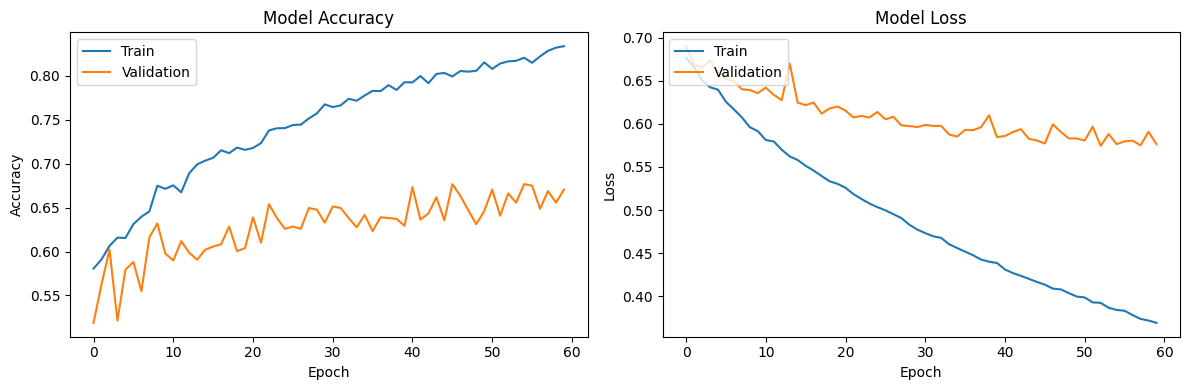

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_1):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_1.history['accuracy'])
    plt.plot(history_1.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_1.history['loss'])
    plt.plot(history_1.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_1)

Model-2:MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the MLP model
def create_mlp(input_shape):
    model = Sequential()

    # Input dropout
    model.add(Input(shape=input_shape))
    model.add(Dropout(0.1))

    # Flatten the input
    model.add(Flatten())

    # First hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Second hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Third hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.add(Dropout(0.3))

    return model

# Create the model
model_mlp = create_mlp(Config.input_shape)
model_mlp.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │       5,000,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             501 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,502,001 (20.99 MB)

 Trainable params: 5,502,001 (20.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model- for K_NC=2.1.K_C=2.3
checkpoint_2 = ModelCheckpoint(Config.best_model_path_2, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_2 = model_mlp.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_2])

Epoch 1/60
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5492 - loss: 3.1706
Epoch 1: val_accuracy improved from -inf to 0.51446, saving model to best_model_Automatic_Speech_2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5493 - loss: 3.1706 - val_accuracy: 0.5145 - val_loss: 0.9774
Epoch 2/60
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5583 - loss: 2.9458
Epoch 2: val_accuracy improved from 0.51446 to 0.52498, saving model to best_model_Automatic_Speech_2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5583 - loss: 2.9470 - val_accuracy: 0.5250 - val_loss: 0.7720
Epoch 3/60
140/143 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5558 - loss: 3.1727
Epoch 3: val_accuracy improved from 0.52498 to 0.52585, saving model to best_model_Automatic_Speech_2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5559 - loss: 3.1710 - val_accuracy: 0.5259 - val_loss: 0.7406
Epoch 4/60
133/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_mlp.load_weights(Config.best_model_path_2)
loss, accuracy = model_mlp.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6131 - loss: 0.6375
Test loss: 0.6393990516662598
Test accuracy: 0.6086956262588501


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_mlp.load_weights(Config.best_model_path_2)
loss, accuracy = model_mlp.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2192 - loss: 2.3413
Test loss: 1.5566486120224
Test accuracy: 0.5349228382110596


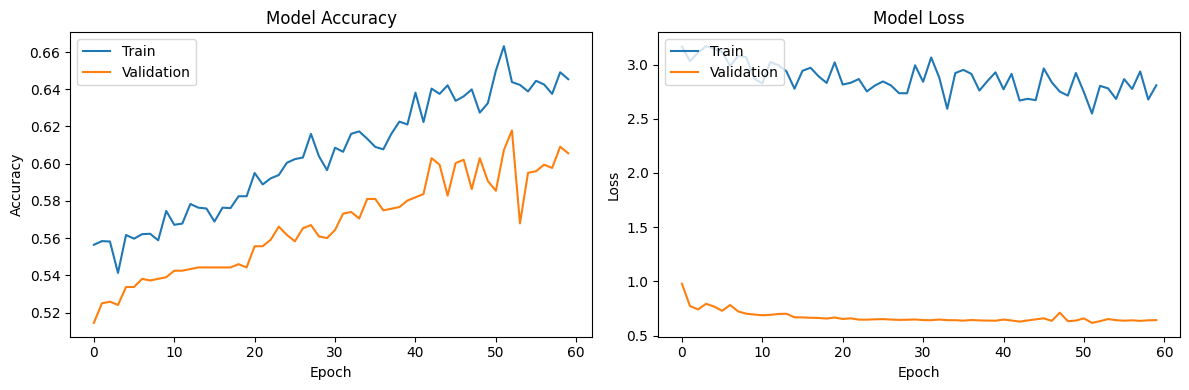

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_2):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_2.history['accuracy'])
    plt.plot(history_2.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_2.history['loss'])
    plt.plot(history_2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_2)

Model-3:FCN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Softmax
from tensorflow.keras.optimizers import Adam

def create_fcn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv1D(filters=64, kernel_size=8, strides=1, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional block
    x = Conv1D(filters=128, kernel_size=5, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolutional block
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Softmax layer (classification layer)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Create the model
model_fcn =  create_fcn_model(Config.input_shape)
model_fcn.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_fcn.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 9993, 64)            │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 9993, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 9993, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9989, 128)           │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9989, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 9989, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 9987, 64)            │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 9987, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 9987, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,393 (263.25 KB)

 Trainable params: 66,881 (261.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Training the model- for K_NC=2.1.K_C=2.3
checkpoint_3 = ModelCheckpoint(Config.best_model_path_3, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history_3 = model_fcn.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_3])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5715 - loss: 0.6824
Epoch 1: val_accuracy improved from -inf to 0.55828, saving model to best_model_Automatic_Speech_3.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.5718 - loss: 0.6821 - val_accuracy: 0.5583 - val_loss: 0.6918
Epoch 2/60
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6855 - loss: 0.5753
Epoch 2: val_accuracy did not improve from 0.55828
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.6857 - loss: 0.5751 - val_accuracy: 0.5057 - val_loss: 0.6908
Epoch 3/60
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7332 - loss: 0.5200
Epoch 3: val_accuracy improved from 0.55828 to 0.59772, saving model to best_model_Automatic_Speech_3.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7332 - loss: 0.5200 - val_accuracy: 0.5977 - val_loss: 0.6710
Epoch 4/60
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7518 - loss: 0.5061
Epoch 4: val_accuracy improved f

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_fcn.load_weights(Config.best_model_path_3)
loss, accuracy = model_fcn.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9238 - loss: 0.2407
Test loss: 0.23605215549468994
Test accuracy: 0.924964964389801


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_fcn.load_weights(Config.best_model_path_3)
loss, accuracy = model_fcn.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8330 - loss: 0.5034
Test loss: 1.1426243782043457
Test accuracy: 0.7272089719772339


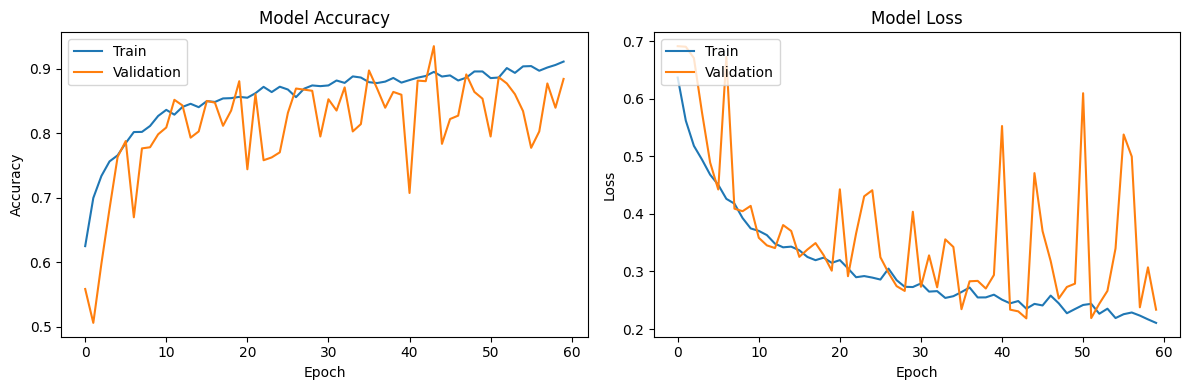

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_3):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_3.history['accuracy'])
    plt.plot(history_3.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_3.history['loss'])
    plt.plot(history_3.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit
plot_training_history(history_3)

Model-4: LKCNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, ReLU

def create_lkcnn(input_shape):
    model = Sequential()

    # First convolutional layer
    model.add(Conv1D(filters=5, kernel_size=100, padding='same', input_shape=input_shape))
    model.add(ReLU())

    # Second convolutional layer
    model.add(Conv1D(filters=5, kernel_size=100, padding='same'))
    model.add(ReLU())

    # Max pooling layer
    model.add(MaxPooling1D(pool_size=2))

    # Dropout layer
    model.add(Dropout(0.5))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(100))
    model.add(ReLU())

    # Fully connected layer 2
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    return model

In [ ]:
# Create the model
model_lkcnn = create_lkcnn(Config.input_shape)
model_lkcnn.compile(optimizer=Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_lkcnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 10000, 5)            │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 10000, 5)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 10000, 5)            │           2,505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 10000, 5)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5000, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5000, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │       2,500,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,503,211 (9.55 MB)

 Trainable params: 2,503,211 (9.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
checkpoint_5 = ModelCheckpoint(Config.best_model_path_5, monitor='val_accuracy', save_best_only=True, mode='max')
history_5 = model_lkcnn.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_5])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9134 - loss: 0.1881 - val_accuracy: 0.8703 - val_loss: 0.3268
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9086 - loss: 0.1824 - val_accuracy: 0.8668 - val_loss: 0.3478
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9075 - loss: 0.1847 - val_accuracy: 0.8685 - val_loss: 0.3464
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9215 - loss: 0.1650 - val_accuracy: 0.8738 - val_loss: 0.3448
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9243 - loss: 0.1598 - val_accuracy: 0.8755 - val_loss: 0.3339
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9272 - loss: 0.1562 - val_accuracy: 0.8834 - val_loss: 0.3211
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9284 - loss: 0.1537 - val_accuracy: 0.8729 - val_loss: 0.3324
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9314 - loss: 0.1475 - val_

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_lkcnn.load_weights(Config.best_model_path_5)
loss, accuracy = model_lkcnn.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9269 - loss: 0.3898
Test loss: 0.3930099904537201
Test accuracy: 0.926367461681366


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_lkcnn.load_weights(Config.best_model_path_5)
loss, accuracy = model_lkcnn.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7390 - loss: 1.0170
Test loss: 0.6446411609649658
Test accuracy: 0.84263676404953


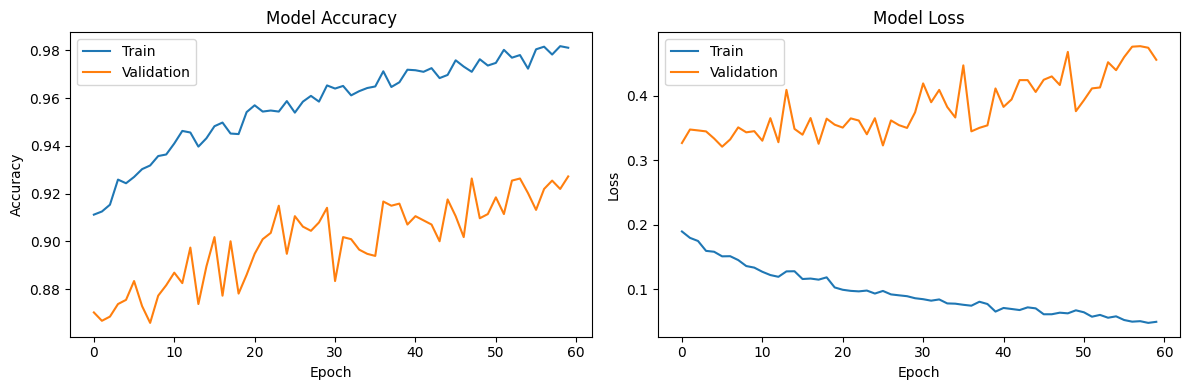

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_5):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_5.history['accuracy'])
    plt.plot(history_5.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_5.history['loss'])
    plt.plot(history_5.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_5)

Proposed_2 = After removing Bi-LSTM and adding attention between residual blocks.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Activation, Bidirectional, Add, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
#from tensorflow_addons.layers import WeightNormalization

class Attention(Layer):
    def _init_(self, **kwargs):
        super(Attention, self)._init_(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x + x * a  # Adding skip connection
        #return K.sum(output, axis=1)
        return output


def residual_block(x, filters, kernel_size, dilation_rate, pool_size):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(Config.l2_lambda))(x)     #Removing Weight Normalization
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size)(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(Config.l2_lambda))(shortcut)                              #Removing Weight Normalization
    shortcut = MaxPooling1D(pool_size)(shortcut)
    x = Add()([x, shortcut])
    return x

def create_network_with_attention_and_dilation(input_shape):
    input_layer = Input(shape=input_shape)

    # CNN part with residual blocks and dilation
    x = residual_block(input_layer, 64, 3, 1, 2)#Add attention layer between the blocks
    x = Attention()(x)
    x = residual_block(x, 128, 3, 2, 2)
    x = Attention()(x)
    x = residual_block(x, 256, 3, 4, 2)
    x = Dropout(0.3)(x)

    # Batch normalization before the start of BiLSTM layers
    x = BatchNormalization()(x)

    # BiLSTM part
    #x = Bidirectional(LSTM(128, return_sequences=True))(x)
    #x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Batch normalization after the BiLSTM layers
    #x = BatchNormalization()(x)

    # Attention layer
    x = Attention()(x)
    x = BatchNormalization()(x)

    # Global Average Pooling layer
    x = GlobalAveragePooling1D()(x)  # This reduces the dimensions

    # Dense Projection
    x = (Dense(128, activation='relu', kernel_regularizer=l2(Config.l2_lambda))(x))                                             #Removing Weight Normalization
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Instantiate and compile the model
model_att_with_dil = create_network_with_attention_and_dilation(Config.input_shape)
model_att_with_dil.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_att_with_dil.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 64)      │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 64)      │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 10000, 64)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 10000, 64)      │         12,352 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 10000, 64)      │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 10000, 64)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 10000, 64)      │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 5000, 64)       │              0 │ activation_1[0][0]     │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 5000, 64)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 5000, 64)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 5000, 64)       │          4,160 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 5000, 128)      │         24,704 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 5000, 128)      │            512 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 5000, 128)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 5000, 128)      │         49,280 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 548,609 (2.09 MB)

 Trainable params: 545,793 (2.08 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Train the model
checkpoint = ModelCheckpoint(Config.best_model_path_new, monitor='val_accuracy', save_best_only=True, mode='max')
history = model_att_with_dil.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 332ms/step - accuracy: 0.6334 - loss: 1.7463 - val_accuracy: 0.5022 - val_loss: 1.9532
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 228ms/step - accuracy: 0.8224 - loss: 1.4603 - val_accuracy: 0.5679 - val_loss: 1.7678
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.8575 - loss: 1.3416 - val_accuracy: 0.7230 - val_loss: 1.5556
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.8811 - loss: 1.2644 - val_accuracy: 0.8133 - val_loss: 1.4095
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.8874 - loss: 1.2085 - val_accuracy: 0.8528 - val_loss: 1.2106
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.8896 - loss: 1.1799 - val_accuracy: 0.9106 - val_loss: 1.1249
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 231ms/step - accuracy: 0.8904 - loss: 1.1247 - val_accuracy: 0.9369 - val_loss: 1.0816
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 231ms/step - accuracy: 0.9010 - loss: 1

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_att_with_dil.load_weights(Config.best_model_path_new)
loss, accuracy = model_att_with_dil.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9711 - loss: 0.4250
Test loss: 0.41863730549812317
Test accuracy: 0.969845712184906


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_att_with_dil.load_weights(Config.best_model_path_new)
loss, accuracy = model_att_with_dil.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9386 - loss: 0.5281
Test loss: 0.8244814276695251
Test accuracy: 0.8182328343391418


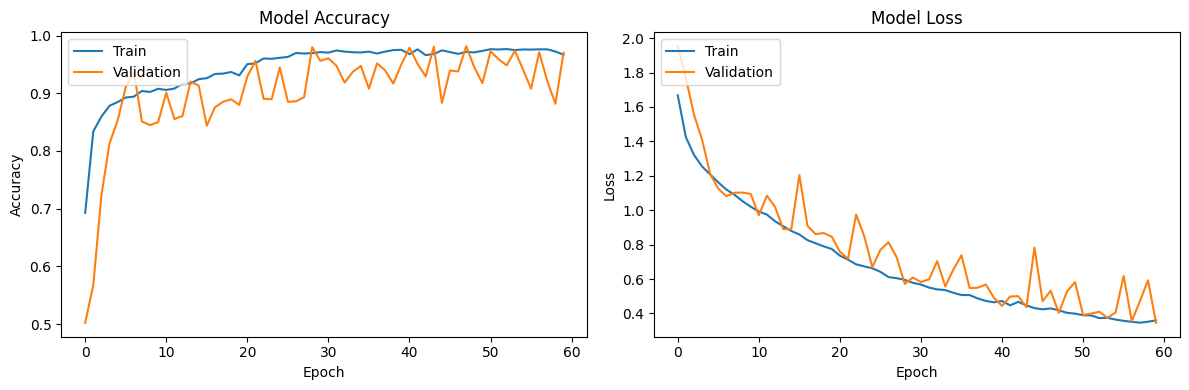

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

**ResNet2**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Add, Activation, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam

def fcn_block(x, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, kernel_size):
    shortcut = x
    x = fcn_block(x, filters, kernel_size)
    x = fcn_block(x, filters, kernel_size)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet(input_shape, nb_classes=1):
    inputs = Input(shape=input_shape)
    x = BatchNormalization()(inputs)

    # First residual block with 64 filters
    x = residual_block(x, 64, 8)

    # Second residual block with 128 filters
    x = residual_block(x, 128, 5)

    # Third residual block with 128 filters
    x = residual_block(x, 128, 3)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Dense layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Instantiate and compile the model
model_resnet2 = create_resnet(Config.input_shape)
model_resnet2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_resnet2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 1)       │              4 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 64)      │            576 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 10000, 64)      │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 10000, 64)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 10000, 64)      │         32,832 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 10000, 64)      │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 10000, 64)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 10000, 64)      │         32,832 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 10000, 64)      │            128 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 10000, 64)      │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 10000, 64)      │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10000, 64)      │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 10000, 64)      │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 10000, 128)     │         41,088 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 10000, 128)     │            512 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 432,453 (1.65 MB)

 Trainable params: 430,147 (1.64 MB)

 Non-trainable params: 2,306 (9.01 KB)

In [ ]:
# Train the model
checkpoint_r = ModelCheckpoint(Config.best_model_path_r, monitor='val_accuracy', save_best_only=True, mode='max')
history_r = model_resnet2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_r])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 406ms/step - accuracy: 0.6669 - loss: 0.5804 - val_accuracy: 0.5022 - val_loss: 0.7426
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 56s 329ms/step - accuracy: 0.8392 - loss: 0.3290 - val_accuracy: 0.5557 - val_loss: 0.9511
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 349ms/step - accuracy: 0.8859 - loss: 0.2501 - val_accuracy: 0.7967 - val_loss: 0.3811
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 333ms/step - accuracy: 0.8952 - loss: 0.2229 - val_accuracy: 0.8668 - val_loss: 0.2791
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 332ms/step - accuracy: 0.9114 - loss: 0.1882 - val_accuracy: 0.8624 - val_loss: 0.2456
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 349ms/step - accuracy: 0.9262 - loss: 0.1790 - val_accuracy: 0.8519 - val_loss: 0.2765
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 333ms/step - accuracy: 0.9407 - loss: 0.1501 - val_accuracy: 0.8528 - val_loss: 0.4358
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 333ms/step - accuracy: 0.9450 - loss: 0

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_resnet2.load_weights(Config.best_model_path_r)
loss, accuracy = model_resnet2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9800 - loss: 0.0389
Test loss: 0.034613464027643204
Test accuracy: 0.9838709831237793


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_resnet2.load_weights(Config.best_model_path_r)
loss, accuracy = model_resnet2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.8439 - loss: 0.9268
Test loss: 2.930387020111084
Test accuracy: 0.5610098242759705


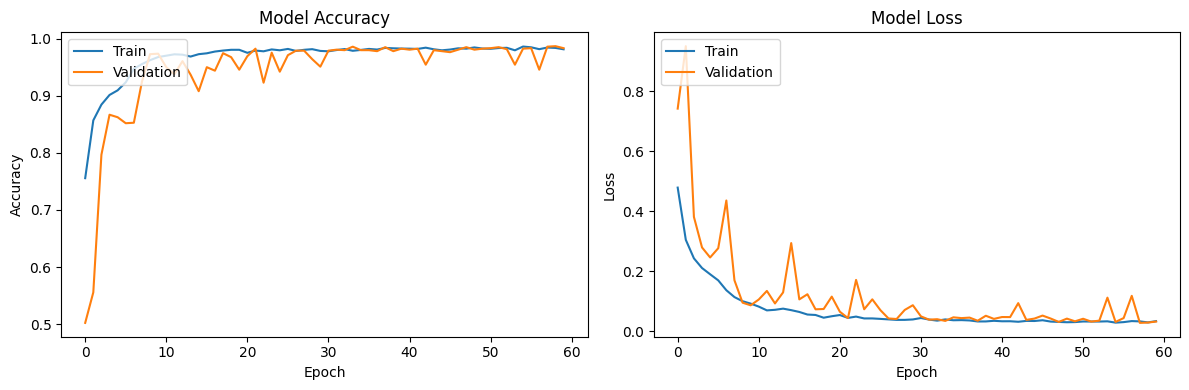

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_r):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_r.history['accuracy'])
    plt.plot(history_r.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_r.history['loss'])
    plt.plot(history_r.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_r)

 **Res-TSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

#ResNet-Style Module 1D
class RSM1D(layers.Layer):
    def __init__(self, channels_in, channels_out):
        super(RSM1D, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.nin = layers.Conv1D(filters=channels_out, kernel_size=1, use_bias=False)

    def call(self, x):
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        y = tf.nn.relu(self.bn2(self.conv2(y)))
        y = self.conv3(y)
        x = self.nin(x)
        x = tf.nn.relu(self.bn3(x + y))
        return x

#Res-TSSDNet
#class SSDNet1D(models.Model):
    #def __init__(self):
        # super(SSDNet1D, self).__init__()
        # self.conv1 = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)
        # self.bn1 = layers.BatchNormalization()
        # self.RSM1 = RSM1D(16, 32)
        # self.RSM2 = RSM1D(32, 64)
        # self.RSM3 = RSM1D(64, 128)
        # self.RSM4 = RSM1D(128, 128)
        # self.fc1 = layers.Dense(64)
        # self.fc2 = layers.Dense(32)
        # self.out = layers.Dense(2)

    # def call(self, x):
    #     x = tf.nn.relu(self.bn1(self.conv1(x)))
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     #stacked ResNet-Style Modules
    #     x = self.RSM1(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM2(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM3(x)
    #     x = tf.nn.max_pool1d(x, pool_size=4, strides=4, padding='same')
    #     x = self.RSM4(x)
    #     x = tf.nn.max_pool1d(x, pool_size=375, strides=375, padding='same')
    #     x = layers.Flatten()(x)
    #     x = tf.nn.relu(self.fc1(x))
    #     x = tf.nn.relu(self.fc2(x))
    #     x = self.out(x)
    #     return x

#Res-TSSDNet
def create_ssdnet1d(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    #x = tf.nn.relu(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked ResNet-Style Modules
    x = RSM1D(16, 32)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(32, 64)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(128, 128)(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Flatten()(x)
    #x = tf.nn.relu(layers.Dense(64)(x))
    x = layers.Dense(64)(x)  # Remove tf.nn.relu
    x = layers.ReLU()(x) # Use LeakyReLU layer instead
    #x = tf.nn.relu(layers.Dense(32)(x))
    x = layers.Dense(32)(x)  # Remove tf.nn.relu
    x = layers.ReLU()(x) # Use LeakyReLU layer instead
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_ssdnet1d = create_ssdnet1d(Config.input_shape)
model_ssdnet1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_ssdnet1d.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 10000, 16)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 10000, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 10000, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2500, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d (RSM1D)                        │ (None, 2500, 32)            │           8,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 625, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_1 (RSM1D)                      │ (None, 625, 64)             │          33,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 157, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_2 (RSM1D)                      │ (None, 157, 128)            │         132,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rsm1d_3 (RSM1D)                      │ (None, 40, 128)             │         165,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 350,641 (1.34 MB)

 Trainable params: 348,497 (1.33 MB)

 Non-trainable params: 2,144 (8.38 KB)

In [ ]:
# Train the model
checkpoint_s = ModelCheckpoint(Config.best_model_path_s, monitor='val_accuracy', save_best_only=True, mode='max')
history_s = model_ssdnet1d.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_s])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.6185 - loss: 0.6645 - val_accuracy: 0.5022 - val_loss: 0.6980
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7970 - loss: 0.4343 - val_accuracy: 0.5513 - val_loss: 0.7264
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8498 - loss: 0.3166 - val_accuracy: 0.6284 - val_loss: 0.7759
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8936 - loss: 0.2484 - val_accuracy: 0.6670 - val_loss: 0.7152
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9064 - loss: 0.2069 - val_accuracy: 0.8002 - val_loss: 0.4589
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9276 - loss: 0.1603 - val_accuracy: 0.9422 - val_loss: 0.1377
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9339 - loss: 0.1483 - val_accuracy: 0.8712 - val_loss: 0.2643
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9446 - loss: 0.1250 - val_ac

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_ssdnet1d.load_weights(Config.best_model_path_s)
loss, accuracy = model_ssdnet1d.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9437 - loss: 0.1086
Test loss: 0.10354038327932358
Test accuracy: 0.948106586933136


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_ssdnet1d.load_weights(Config.best_model_path_s)
loss, accuracy = model_ssdnet1d.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9518 - loss: 0.1530
Test loss: 0.2933838367462158
Test accuracy: 0.9129032492637634


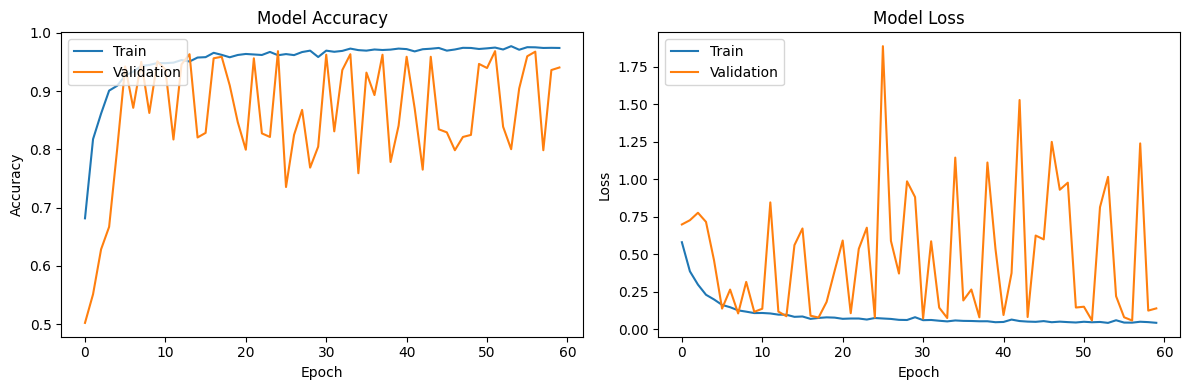

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_s):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_s.history['accuracy'])
    plt.plot(history_s.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_s.history['loss'])
    plt.plot(history_s.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_s)

**Inception style, Inc-TSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dilated Convolution Module 1D (equivalent to ISM1D in the previous code)
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()

    def call(self, x):
        y1 = tf.nn.relu(self.bn1(self.conv1(x)))
        y2 = tf.nn.relu(self.bn2(self.conv2(x)))
        y3 = tf.nn.relu(self.bn3(self.conv3(x)))
        y4 = tf.nn.relu(self.bn4(self.conv4(x)))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        return y

# Inc-TSSDNet
def create_inc_tssdnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    #x = tf.nn.relu(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    # x = DilatedConvModule(16, 32)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(32, 64)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(64, 128)(x)
    # x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    # x = DilatedConvModule(128, 128)(x)
    # x = layers.GlobalMaxPooling1D()(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Flatten()(x)
    #x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64)(x)  # Remove tf.nn.relu
    x = layers.ReLU()(x) # Use LeakyReLU layer instead
    #x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32)(x)  # Remove tf.nn.relu
    x = layers.ReLU()(x) # Use LeakyReLU layer instead
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification


    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_Incnet = create_inc_tssdnet(Config.input_shape)
model_Incnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_28 (Conv1D)                   │ (None, 10000, 16)           │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 10000, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 10000, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 2500, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module                  │ (None, 2500, 240)           │          12,480 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 625, 240)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_1                │ (None, 625, 480)            │         347,520 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 157, 480)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_2                │ (None, 157, 960)            │       1,386,240 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 40, 960)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dilated_conv_module_3                │ (None, 40, 1920)            │       5,537,280 │
│ (DilatedConvModule)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 1920)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,408,753 (28.26 MB)

 Trainable params: 7,401,521 (28.23 MB)

 Non-trainable params: 7,232 (28.25 KB)

In [ ]:
# Train the model
checkpoint_i = ModelCheckpoint(Config.best_model_path_i, monitor='val_accuracy', save_best_only=True, mode='max')
history_i = model_Incnet.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_i])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 293ms/step - accuracy: 0.7325 - loss: 0.4851 - val_accuracy: 0.5022 - val_loss: 0.9051
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.8556 - loss: 0.2668 - val_accuracy: 0.5057 - val_loss: 1.5506
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.8874 - loss: 0.2135 - val_accuracy: 0.8615 - val_loss: 0.2770
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9172 - loss: 0.1683 - val_accuracy: 0.8352 - val_loss: 0.3207
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9197 - loss: 0.1547 - val_accuracy: 0.8624 - val_loss: 0.2296
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9158 - loss: 0.1658 - val_accuracy: 0.9343 - val_loss: 0.1409
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.9392 - loss: 0.1223 - val_accuracy: 0.8528 - val_loss: 0.3661
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.9372 - loss: 0.1235 

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_Incnet.load_weights(Config.best_model_path_i)
loss, accuracy = model_Incnet.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9668 - loss: 0.0863
Test loss: 0.08812509477138519
Test accuracy: 0.9628331065177917


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Incnet.load_weights(Config.best_model_path_i)
loss, accuracy = model_Incnet.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8005 - loss: 0.9610
Test loss: 0.9100136160850525
Test accuracy: 0.8241234421730042


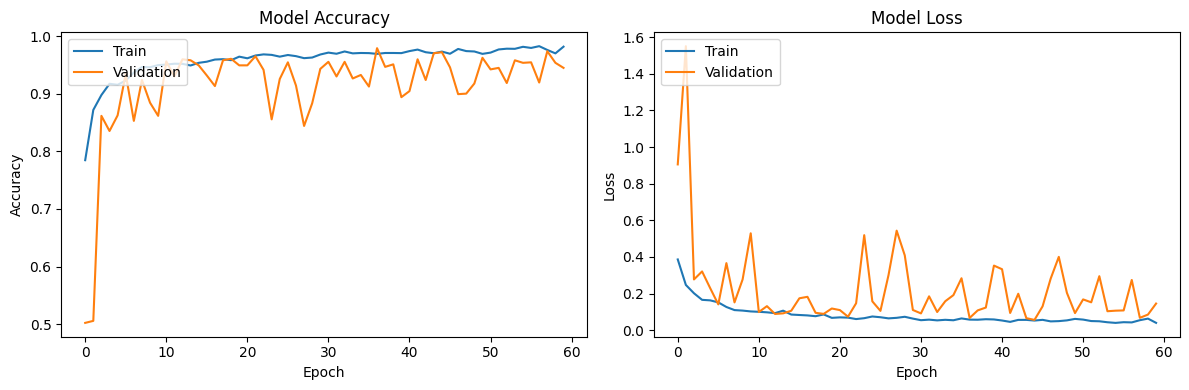

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_i):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_i.history['accuracy'])
    plt.plot(history_i.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_i.history['loss'])
    plt.plot(history_i.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_i)

# **Mod-IncNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Dilated Convolution Module 1D
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()

    def call(self, x):
        y1 = tf.nn.relu(self.bn1(self.conv1(x)))
        y2 = tf.nn.relu(self.bn2(self.conv2(x)))
        y3 = tf.nn.relu(self.bn3(self.conv3(x)))
        y4 = tf.nn.relu(self.bn4(self.conv4(x)))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        return y

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    return block

# Create the model with residual blocks and dilated conv modules
def create_inc_tssdnet_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)

    # Global MaxPooling
    x = layers.GlobalMaxPooling1D()(x)

    # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Reshape for 1D Convolution
    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final Layers with Dropout
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64)(x)  # Remove tf.nn.relu
    x = layers.ReLU()(x) # Use LeakyReLU layer instead
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32)(x)  # Remove tf.nn.relu
    x = layers.ReLU()(x) # Use LeakyReLU layer instead
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Create the model with the specified input shape
model_Incnet_m = create_inc_tssdnet_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Incnet_m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet_m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 16)      │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 16)      │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 10000, 16)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 2500, 16)       │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module       │ (None, 2500, 240)      │         12,480 │ max_pooling1d[0][0]    │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 625, 240)       │              0 │ dilated_conv_module[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_1     │ (None, 625, 480)       │        347,520 │ max_pooling1d_1[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 157, 480)       │              0 │ dilated_conv_module_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_2     │ (None, 157, 960)       │      1,386,240 │ max_pooling1d_2[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 40, 960)        │              0 │ dilated_conv_module_2… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_3     │ (None, 40, 1920)       │      5,537,280 │ max_pooling1d_3[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 1920)           │              0 │ dilated_conv_module_3… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1920)        │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)   

 Total params: 214,085,233 (816.67 MB)

 Trainable params: 214,031,921 (816.47 MB)

 Non-trainable params: 53,312 (208.25 KB)

In [ ]:
# Train the model
checkpoint_m = ModelCheckpoint(Config.best_model_path_m, monitor='val_accuracy', save_best_only=True, mode='max')
history_m = model_Incnet_m.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_m])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.7094 - loss: 176.9659 - val_accuracy: 0.5022 - val_loss: 63.3141
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 246ms/step - accuracy: 0.8530 - loss: 49.4577 - val_accuracy: 0.5022 - val_loss: 23.6917
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8697 - loss: 18.5498 - val_accuracy: 0.6722 - val_loss: 9.3365
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.8937 - loss: 7.2912 - val_accuracy: 0.8317 - val_loss: 3.7399
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.8987 - loss: 2.9910 - val_accuracy: 0.8536 - val_loss: 1.6446
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9158 - loss: 1.3392 - val_accuracy: 0.9062 - val_loss: 0.8028
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 254ms/step - accuracy: 0.9299 - loss: 0.6715 - val_accuracy: 0.8352 - val_loss: 0.9455
Epoch 8/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.9287 - loss: 0.4896 

In [ ]:
# Evaluate the model- for K_NC=2.1, K_C=2.3
model_Incnet_m.load_weights(Config.best_model_path_m)
loss, accuracy = model_Incnet_m.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.9478 - loss: 0.3157
Test loss: 0.30784258246421814
Test accuracy: 0.9523141384124756


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Incnet_m.load_weights(Config.best_model_path_m)
loss, accuracy = model_Incnet_m.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.8504 - loss: 1.1609
Test loss: 0.8402911424636841
Test accuracy: 0.8792426586151123


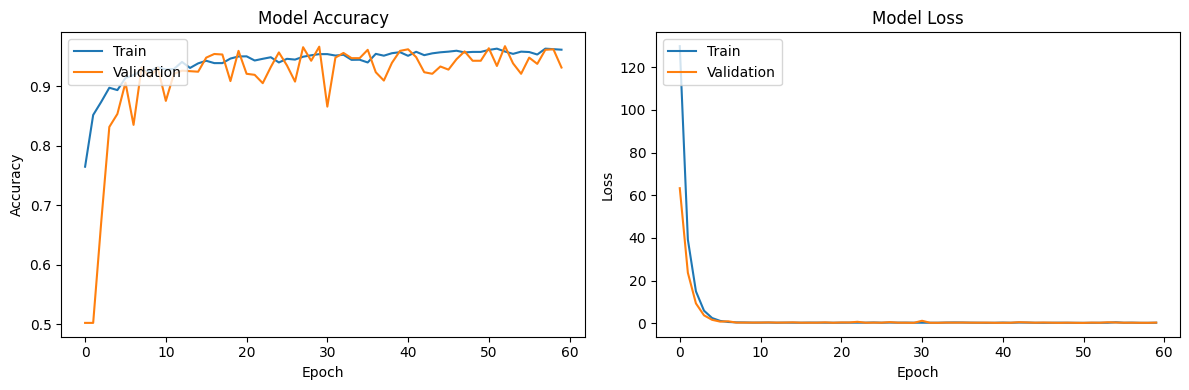

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_m):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_m.history['accuracy'])
    plt.plot(history_m.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_m.history['loss'])
    plt.plot(history_m.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_m)

**Mod_IncNet_2**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Dilated Convolution Module 1D
class DilatedConvModule(layers.Layer):
    def __init__(self, channels_in, channels_out1, channels_out2, channels_out3, channels_out4, dropout_rate=0.3):
        super(DilatedConvModule, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out1, kernel_size=3, padding='same', dilation_rate=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out2, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out3, kernel_size=3, padding='same', dilation_rate=4, use_bias=False)
        self.conv4 = layers.Conv1D(filters=channels_out4, kernel_size=3, padding='same', dilation_rate=8, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        y1 = tf.nn.relu(self.bn1(self.conv1(x), training=training))
        y2 = tf.nn.relu(self.bn2(self.conv2(x), training=training))
        y3 = tf.nn.relu(self.bn3(self.conv3(x), training=training))
        y4 = tf.nn.relu(self.bn4(self.conv4(x), training=training))
        y = tf.concat([y1, y2, y3, y4], axis=-1)
        y = self.dropout(y, training=training)
        return y

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None, dropout_rate=0.3):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    block = layers.Dropout(dropout_rate)(block)
    return block

# Create the model with residual blocks and dilated conv modules
def create_inc_tssdnet_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked Dilated Convolution Modules
    x = DilatedConvModule(16, 16, 32, 64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(240, 32, 64, 128, 256)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(480, 64, 128, 256, 512)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = DilatedConvModule(960, 128, 256, 512, 1024)(x)

    # Global MaxPooling
    x = layers.GlobalMaxPooling1D()(x)

    # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Reshape for 1D Convolution
    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 2):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final Layers with Dropout
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.LeakyReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # For binary classification

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Create the model with the specified input shape
model_Incnet_m2 = create_inc_tssdnet_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Incnet_m2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Incnet_m2.summary()

# Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 16)      │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 16)      │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 10000, 16)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 2500, 16)       │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module       │ (None, 2500, 240)      │         12,480 │ max_pooling1d[0][0]    │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 625, 240)       │              0 │ dilated_conv_module[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_1     │ (None, 625, 480)       │        347,520 │ max_pooling1d_1[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 157, 480)       │              0 │ dilated_conv_module_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_2     │ (None, 157, 960)       │      1,386,240 │ max_pooling1d_2[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 40, 960)        │              0 │ dilated_conv_module_2… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dilated_conv_module_3     │ (None, 40, 1920)       │      5,537,280 │ max_pooling1d_3[0][0]  │
│ (DilatedConvModule)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 1920)           │              0 │ dilated_conv_module_3… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1920)        │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)   

 Total params: 214,085,233 (816.67 MB)

 Trainable params: 214,031,921 (816.47 MB)

 Non-trainable params: 53,312 (208.25 KB)

In [ ]:
# Model Checkpoint
checkpoint_m2 = callbacks.ModelCheckpoint(Config.best_model_path_m2, monitor='val_accuracy', save_best_only=True, mode='max')
history_m2 = model_Incnet_m2.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_m2, lr_scheduler, early_stopping])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.5960 - loss: 175.1878 - val_accuracy: 0.4978 - val_loss: 61.2198 - learning_rate: 1.0000e-04
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.8025 - loss: 48.8934 - val_accuracy: 0.4978 - val_loss: 27.0378 - learning_rate: 1.0000e-04
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.8360 - loss: 22.7181 - val_accuracy: 0.4978 - val_loss: 15.2374 - learning_rate: 1.0000e-04
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.8558 - loss: 13.1693 - val_accuracy: 0.4978 - val_loss: 9.8529 - learning_rate: 1.0000e-04
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 544s 4s/step - accuracy: 0.8701 - loss: 8.4465 - val_accuracy: 0.5110 - val_loss: 6.6295 - learning_rate: 1.0000e-04
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 590s 4s/step - accuracy: 0.8950 - loss: 5.7303 - val_accuracy: 0.5188 - val_loss: 4.7272 - learning_rate: 1.0000e-04
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 

In [ ]:
# Evaluate the model
model_Incnet_m2.load_weights(Config.best_model_path_m2)
loss, accuracy = model_Incnet_m2.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9562 - loss: 0.3722
Test loss: 0.36647096276283264
Test accuracy: 0.9551191926002502


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Incnet_m2.load_weights(Config.best_model_path_m2)
loss, accuracy = model_Incnet_m2.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.8125 - loss: 0.5244
Test loss: 0.586326539516449
Test accuracy: 0.8058906197547913


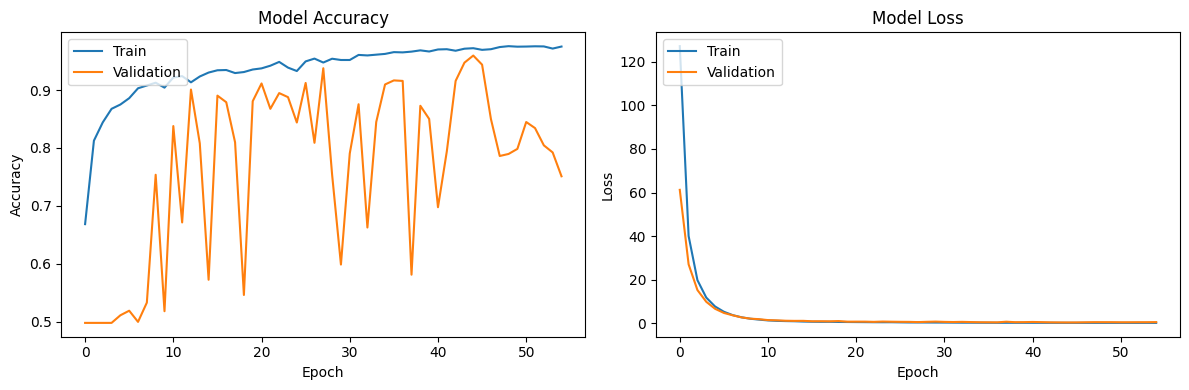

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_m2):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_m2.history['accuracy'])
    plt.plot(history_m2.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_m2.history['loss'])
    plt.plot(history_m2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_m2)

**Mod-ResTSSDNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# ResNet-Style Module 1D
class RSM1D(layers.Layer):
    def __init__(self, channels_in, channels_out):
        super(RSM1D, self).__init__()
        self.conv1 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv2 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.conv3 = layers.Conv1D(filters=channels_out, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.nin = layers.Conv1D(filters=channels_out, kernel_size=1, use_bias=False)

    def call(self, x):
        y = tf.nn.relu(self.bn1(self.conv1(x)))
        y = tf.nn.relu(self.bn2(self.conv2(y)))
        y = self.conv3(y)
        x = self.nin(x)
        x = tf.nn.relu(self.bn3(x + y))
        return x

# Residual Block
def residual_block(l, increase_dim=False, first=False, keep_filter=False, strides=None, r_value=None, dropout_rate=0.3):
    input_num_filters = tf.keras.backend.int_shape(l)[-1]

    if increase_dim:
        first_stride = strides
        out_num_filters = input_num_filters * 2 if not keep_filter else input_num_filters
    else:
        first_stride = 1
        out_num_filters = input_num_filters

    if not first:
        bn_pre_conv = layers.BatchNormalization()(l)
        bn_pre_relu = layers.LeakyReLU()(bn_pre_conv)
    else:
        bn_pre_relu = l

    conv_1 = layers.LeakyReLU()(
        layers.BatchNormalization()(
            layers.Conv1D(filters=out_num_filters, kernel_size=3, strides=first_stride, padding='same', kernel_regularizer=regularizers.l2(r_value))(bn_pre_relu)
        )
    )

    conv_2 = layers.Conv1D(filters=out_num_filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(r_value))(conv_1)

    if increase_dim:
        projection = layers.Conv1D(filters=out_num_filters, kernel_size=1, strides=first_stride, padding='same', use_bias=False, kernel_regularizer=regularizers.l2(r_value))(l)
        block = layers.Add()([conv_2, projection])
    else:
        block = layers.Add()([conv_2, l])

    block = layers.Dropout(dropout_rate)(block)
    return block


# Res-TSSDNet
def create_ssdnet1d_with_residual_and_conv_modules(input_shape, r_value=0.01, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', use_bias=False,  kernel_regularizer=regularizers.l2(r_value))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)

    # Stacked ResNet-Style Modules
    x = RSM1D(16, 32)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(32, 64)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(64, 128)(x)
    x = layers.MaxPooling1D(pool_size=4, strides=4, padding='same')(x)
    x = RSM1D(128, 128)(x)
    x = layers.GlobalMaxPooling1D()(x)

     # Residual Blocks
    x = layers.Reshape((1, -1))(x)  # Reshape for 1D Convolution
    x = residual_block(x, first=True, r_value=r_value)
    for _ in range(1, 3):
        x = residual_block(x, r_value=r_value)

    x = residual_block(x, increase_dim=True, strides=2, r_value=r_value)
    for _ in range(1, 3):
        x = residual_block(x, r_value=r_value)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)


    x = layers.Flatten()(x)
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(r_value))(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Create the model with the specified input shape
model_Restssd = create_ssdnet1d_with_residual_and_conv_modules(Config.input_shape, r_value=0.01, dropout_rate=0.5)
model_Restssd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_Restssd.summary()

# Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10000, 16)      │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10000, 16)      │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 10000, 16)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 2500, 16)       │              0 │ re_lu[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d (RSM1D)             │ (None, 2500, 32)       │          8,576 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 625, 32)        │              0 │ rsm1d[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_1 (RSM1D)           │ (None, 625, 64)        │         33,536 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 157, 64)        │              0 │ rsm1d_1[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_2 (RSM1D)           │ (None, 157, 128)       │        132,608 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 40, 128)        │              0 │ rsm1d_2[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rsm1d_3 (RSM1D)           │ (None, 40, 128)        │        165,376 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ rsm1d_3[0][0]          │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 128)         │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 1, 128)         │         49,280 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 1, 128)         │            512 │ conv1d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,779,377 (6.79 MB)

 Trainable params: 1,772,625 (6.76 MB)

 Non-trainable params: 6,752 (26.38 KB)

In [ ]:
# Model Checkpoint
checkpoint_rtssd = callbacks.ModelCheckpoint(Config.best_model_path_rtssd, monitor='val_accuracy', save_best_only=True, mode='max')
history_rtssd = model_Restssd.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[checkpoint_rtssd, lr_scheduler, early_stopping])

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 186ms/step - accuracy: 0.5028 - loss: 23.8188 - val_accuracy: 0.5022 - val_loss: 17.6346 - learning_rate: 1.0000e-04
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.5386 - loss: 16.2582 - val_accuracy: 0.5022 - val_loss: 12.5534 - learning_rate: 1.0000e-04
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5707 - loss: 11.6910 - val_accuracy: 0.5390 - val_loss: 9.3977 - learning_rate: 1.0000e-04
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5947 - loss: 8.8265 - val_accuracy: 0.6582 - val_loss: 7.3361 - learning_rate: 1.0000e-04
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6340 - loss: 6.9754 - val_accuracy: 0.7064 - val_loss: 5.9602 - learning_rate: 1.0000e-04
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7044 - loss: 5.6792 - val_accuracy: 0.7564 - val_loss: 4.9357 - learning_rate: 1.0000e-04
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/st

In [ ]:
# Evaluate the model
model_Restssd.load_weights(Config.best_model_path_rtssd)
loss, accuracy = model_Restssd.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9778 - loss: 0.1416
Test loss: 0.1415690928697586
Test accuracy: 0.9761570692062378


In [ ]:
#Add
# Evaluate the model- for K_NC=2.0, K_C=2.4
model_Restssd.load_weights(Config.best_model_path_rtssd)
loss, accuracy = model_Restssd.evaluate(X_test_T, y_test_T)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8706 - loss: 0.4586
Test loss: 0.4884268641471863
Test accuracy: 0.8670406937599182


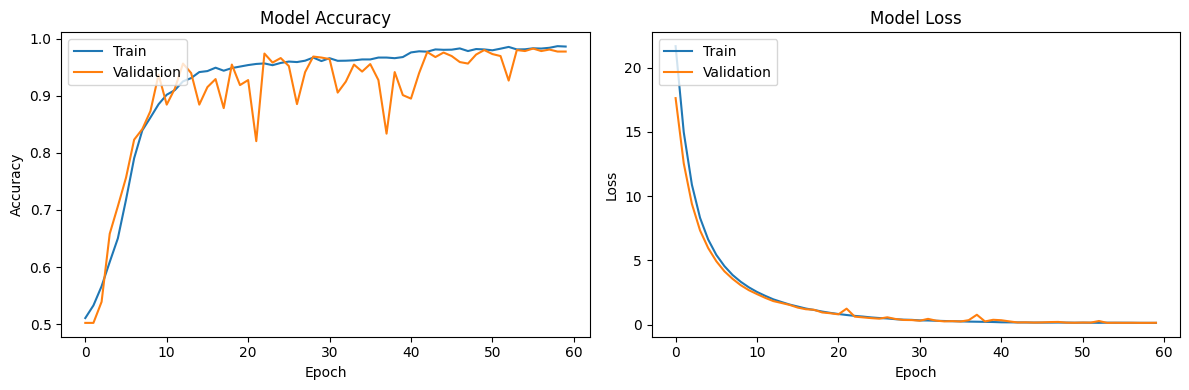

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the history of the training process
def plot_training_history(history_rtssd):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_rtssd.history['accuracy'])
    plt.plot(history_rtssd.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_rtssd.history['loss'])
    plt.plot(history_rtssd.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history_rtssd)